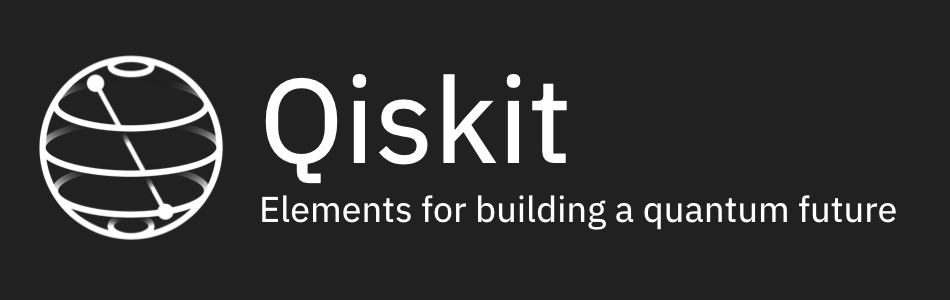

## Purity Randomized Benchmarking


## Introduction

**Purity Randomized Benchmarking** is a variant of the Randomized Benchmarking (RB) method, which quantifies how *coherent* the errors are. The protocol executes the RB sequences containing Clifford gates, and then calculates the *purity* $Tr(\rho^2)$, and fits the purity result to an exponentially decaying curve.

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module in order to perform purity RB.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import the measurement mitigation functions
import qiskit.ignis.mitigation.measurement as mc

#Import Qiskit classes
import qiskit
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, coherent_unitary_error
from qiskit.quantum_info import state_fidelity

## Select the Parameters of the Purity RB Run

First, wee need to choose the regular RB parameters:

- **nseeds**: The number of seeds. For each seed you will get a separate list of output circuits.
- **length_vector**: The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern**: A list of the form [[i],[j],[k],...] or [[i,j],[k,l],...], etc. which will make simultaneous RB sequences. All the patterns should have the same dimetion, namely only 1-qubit sequences Qk or only 2-qubit sequences Qi,Qj, etc. The number of qubits is the sum of the entries.
- **length_multiplier = None**: No length_multiplier for purity RB.
- **seed_offset**: What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs**: If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

As well as another parameter for purity RB:

- **is_purity = True**

In this example we run 2Q purity RB (on qubits Q0,Q1).

In [2]:
# Example of 2-qubits Purity RB
#Number of qubits
nQ = 2
#Number of seeds (random sequences)
nseeds = 3
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q1
rb_pattern = [[0,1]]

## Generate Purity RB sequences

We generate purity RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the purity RB sequences **rb_purity_circs**, which is a list of lists of lists of quantum circuits, we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_purity_circs**: A list of lists of lists of circuits for the purity RB sequences (separate list for each of the $3^n$ options and for each seed).
- **xdata**: The Clifford lengths (with multiplier if applicable).

As well as:

- **npurity**: the number of purity rb circuits (per seed) which equals to $3^n$, where $n$ is the dimension, e.g npurity=3 for 1-qubit RB, npurity=9 for 2-qubit RB.

In order to generate each of the $3^n$ circuits, we need to do (per each of the $n$ qubits) either:
- nothing (Pauli-$Z$), or
- $\pi/2$-rotation around $x$ (Pauli-$X$), or
- $\pi/2$-rotation around $y$ (Pauli-$Y$),

and then measure the result.

In [3]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['is_purity'] = True
rb_purity_circs, xdata, npurity = rb.randomized_benchmarking_seq(**rb_opts)
print (npurity)

9


To illustrate, we print the circuit names for purity RB (for length=0 and seed=0):

In [4]:
for j in range(len(rb_purity_circs[0])):
    print (rb_purity_circs[0][j][0].name)

rb_purity_ZZ_length_0_seed_0
rb_purity_XZ_length_0_seed_0
rb_purity_YZ_length_0_seed_0
rb_purity_ZX_length_0_seed_0
rb_purity_XX_length_0_seed_0
rb_purity_YX_length_0_seed_0
rb_purity_ZY_length_0_seed_0
rb_purity_XY_length_0_seed_0
rb_purity_YY_length_0_seed_0


As an example, we print the circuit corresponding to the first RB sequences, for the first and last parameter.

In [5]:
for i in {0, npurity-1}:
    print ("circ no. ", i)
    print (rb_purity_circs[0][i][0])

circ no.  0
         ┌───┐┌─────┐┌───┐     ┌───┐┌───┐┌───┐ ░  ┌───┐ ┌─────┐┌───┐     ┌───┐»
qr_0: |0>┤ H ├┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├┤ Y ├─░──┤ Y ├─┤ Sdg ├┤ H ├──■──┤ H ├»
         ├───┤├─────┤├───┤┌─┴─┐├───┤├───┤└───┘ ░ ┌┴───┴┐└┬───┬┘└───┘┌─┴─┐├───┤»
qr_1: |0>┤ H ├┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├──────░─┤ Sdg ├─┤ H ├──────┤ X ├┤ H ├»
         └───┘└─────┘└───┘└───┘└───┘└───┘      ░ └─────┘ └───┘      └───┘└───┘»
 cr_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_1: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌───┐┌───┐┌─┐   
«qr_0: ┤ S ├┤ H ├┤M├───
«      ├───┤├───┤└╥┘┌─┐
«qr_1: ┤ S ├┤ H ├─╫─┤M├
«      └───┘└───┘ ║ └╥┘
«cr_0: ═══════════╩══╬═
«                    ║ 
«cr_1: ══════════════╩═
«                      
circ no.  8
         ┌───┐┌─────┐┌───┐     ┌───┐┌───

## Define a non-coherent noise model

We define a non-coherent noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT gate.

In [6]:
noise_model = noise.NoiseModel()
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

We can execute the purity RB sequences either using a Qiskit Aer Simulator (with some noise model) or using an IBMQ provider, and obtain a list of results, `result_list`.

In [7]:
#Execute purity RB circuits 
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
purity_result_list = []
import time
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        print('Executing seed %d purity %d length %d'%(rb_seed, d, len(nCliffs)))
        new_circ = rb_purity_circs[rb_seed][d]
        job = qiskit.execute(new_circ, backend=backend, noise_model=noise_model, shots=shots, basis_gates=['u1','u2','u3','cx'])
        purity_result_list.append(job.result())
print("Finished Simulating Purity RB Circuits")

Executing seed 0 purity 0 length 10
Executing seed 0 purity 1 length 10
Executing seed 0 purity 2 length 10
Executing seed 0 purity 3 length 10
Executing seed 0 purity 4 length 10
Executing seed 0 purity 5 length 10
Executing seed 0 purity 6 length 10
Executing seed 0 purity 7 length 10
Executing seed 0 purity 8 length 10
Executing seed 1 purity 0 length 10
Executing seed 1 purity 1 length 10
Executing seed 1 purity 2 length 10
Executing seed 1 purity 3 length 10
Executing seed 1 purity 4 length 10
Executing seed 1 purity 5 length 10
Executing seed 1 purity 6 length 10
Executing seed 1 purity 7 length 10
Executing seed 1 purity 8 length 10
Executing seed 2 purity 0 length 10
Executing seed 2 purity 1 length 10
Executing seed 2 purity 2 length 10
Executing seed 2 purity 3 length 10
Executing seed 2 purity 4 length 10
Executing seed 2 purity 5 length 10
Executing seed 2 purity 6 length 10
Executing seed 2 purity 7 length 10
Executing seed 2 purity 8 length 10
Finished Simulating Purity R

## Fit the results

Calculate the *purity* $Tr(\rho^2)$ as the sum $\sum_k \langle P_k \rangle ^2/2^n$, and fit the purity result against an exponentially decaying function to obtain $\alpha$.

In [8]:
rbfit_purity = rb.PurityRBFitter(purity_result_list, npurity, xdata, rb_opts['rb_pattern'])

Print the fit result (separately for each pattern):

In [9]:
print ("fit:", rbfit_purity.fit)

fit: [{'params': array([0.73977966, 0.98520199, 0.26021644]), 'params_err': array([0.01003959, 0.00036658, 0.00230204]), 'epc': 0.022032772471091477, 'epc_err': 0.0005622978552849558, 'pepc': 0.01109850409768326, 'pepc_err': 0.0002790609527025816}]


## Plot the results and the fit

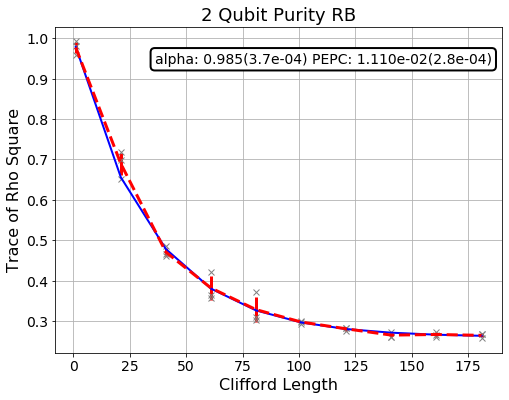

In [10]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_purity.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Purity RB'%(nQ), fontsize=18)

plt.show()

## Standard RB results

For comparison, we also print the standard RB fit results:

In [11]:
standard_result_list = []
count = 0
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        if d==0:
            standard_result_list.append(purity_result_list[count])
        count += 1

In [12]:
rbfit_standard = rb.RBFitter(standard_result_list, xdata, rb_opts['rb_pattern'])

In [13]:
print (rbfit_standard.fit)

[{'params': array([0.8009915 , 0.98701723, 0.19022488]), 'params_err': array([0.02149491, 0.00075144, 0.02250058]), 'epc': 0.009737077645084719, 'epc_err': 0.000570990042250133}]


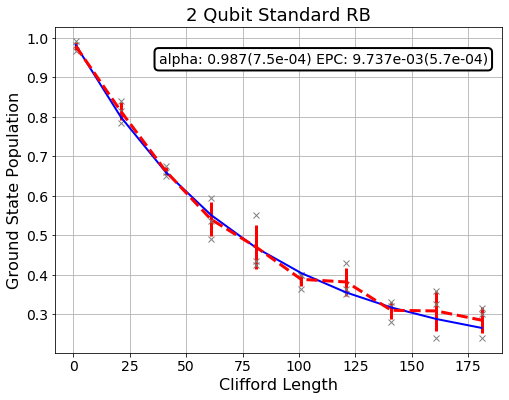

In [14]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_standard.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Standard RB'%(nQ), fontsize=18)

plt.show()

## Measurement noise model and measurement error mitigation 

Since part of the noise might be due to measurement errors and not only due to coherent errors, we repeat the example with measurement noise and demonstrate a mitigation of measurement errors before calculating the purity RB fitter.

In [15]:
#Add measurement noise
for qi in range(nQ):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
    noise_model.add_readout_error(read_err,[qi])
    
#Generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1])

backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 200

#Execute the calibration circuits
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=shots, noise_model=noise_model)
meas_result = job_cal.result()

#Execute the purity RB circuits 
meas_purity_result_list = []
for rb_seed in range(len(rb_purity_circs)):    
    for d in range(npurity):
        print('Executing seed %d purity %d length %d'%(rb_seed, d, len(nCliffs)))
        new_circ = rb_purity_circs[rb_seed][d]
        job_pur = qiskit.execute(new_circ, backend=backend, shots=shots, noise_model=noise_model, basis_gates=['u1','u2','u3','cx'])
        meas_purity_result_list.append(job_pur.result())

Executing seed 0 purity 0 length 10
Executing seed 0 purity 1 length 10
Executing seed 0 purity 2 length 10
Executing seed 0 purity 3 length 10
Executing seed 0 purity 4 length 10
Executing seed 0 purity 5 length 10
Executing seed 0 purity 6 length 10
Executing seed 0 purity 7 length 10
Executing seed 0 purity 8 length 10
Executing seed 1 purity 0 length 10
Executing seed 1 purity 1 length 10
Executing seed 1 purity 2 length 10
Executing seed 1 purity 3 length 10
Executing seed 1 purity 4 length 10
Executing seed 1 purity 5 length 10
Executing seed 1 purity 6 length 10
Executing seed 1 purity 7 length 10
Executing seed 1 purity 8 length 10
Executing seed 2 purity 0 length 10
Executing seed 2 purity 1 length 10
Executing seed 2 purity 2 length 10
Executing seed 2 purity 3 length 10
Executing seed 2 purity 4 length 10
Executing seed 2 purity 5 length 10
Executing seed 2 purity 6 length 10
Executing seed 2 purity 7 length 10
Executing seed 2 purity 8 length 10


In [16]:
#Fitters
meas_fitter = mc.CompleteMeasFitter(meas_result, state_labels)
rbfit_purity = rb.PurityRBFitter(meas_purity_result_list, npurity, xdata, rb_opts['rb_pattern'])

#no correction
rho_pur = rbfit_purity.fit
print('Fit (no correction) =', rho_pur)

#correct data
correct_purity_result_list = []
for meas_result in meas_purity_result_list:    
    correct_purity_result_list.append(meas_fitter.filter.apply(meas_result))

#with correction
rbfit_cor = rb.PurityRBFitter(correct_purity_result_list, npurity, xdata, rb_opts['rb_pattern'])        
rho_pur = rbfit_cor.fit
print('Fit (w/ correction) =', rho_pur)

Fit (no correction) = [{'params': array([0.22661774, 0.97110583, 0.28600311]), 'params_err': array([0.05478035, 0.00548312, 0.00125466]), 'epc': 0.04271509832999962, 'epc_err': 0.008594469641910286, 'pepc': 0.02167062653460128, 'pepc_err': 0.004234697253042689}]
Fit (w/ correction) = [{'params': array([0.69914885, 0.98656538, 0.34398584]), 'params_err': array([0.03379164, 0.00152947, 0.00304292]), 'epc': 0.02001657046756572, 'epc_err': 0.002341225009239348, 'pepc': 0.010075968663454171, 'pepc_err': 0.0011627225454105146}]


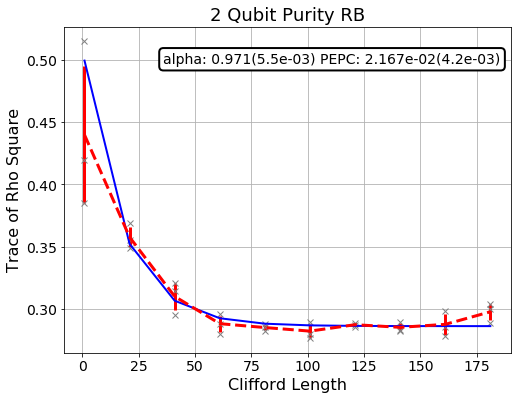

In [17]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_purity.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Purity RB'%(nQ), fontsize=18)

plt.show()

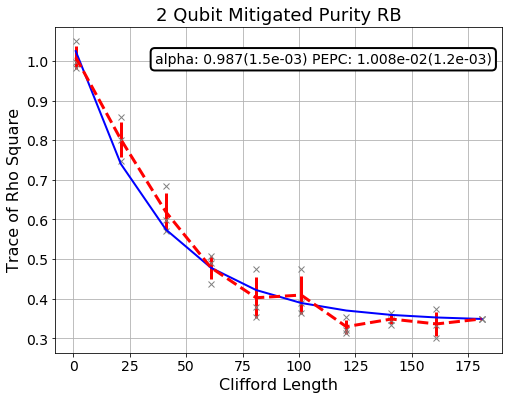

In [18]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_cor.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Mitigated Purity RB'%(nQ), fontsize=18)

plt.show()

## Define a coherent noise model

We define a coherent noise model for the simulator. In this example we expect the purity RB to measure no errors, but standard RB will still measure a non-zero error.

In [19]:
err_unitary = np.zeros([2, 2], dtype=complex)
angle_err = 0.1
for i in range(2):
    err_unitary[i, i] = np.cos(angle_err)
    err_unitary[i, (i+1) % 2] = np.sin(angle_err)
err_unitary[0, 1] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error, 'u3')

In [20]:
#Execute purity RB circuits 
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
coherent_purity_result_list = []
import time
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        print('Executing seed %d purity %d length %d'%(rb_seed, d, len(nCliffs)))
        new_circ = rb_purity_circs[rb_seed][d]
        job = qiskit.execute(new_circ, backend=backend, shots=shots, noise_model=noise_model, basis_gates=['u1','u2','u3','cx'])
        coherent_purity_result_list.append(job.result())
print("Finished Simulating Purity RB Circuits")

Executing seed 0 purity 0 length 10
Executing seed 0 purity 1 length 10
Executing seed 0 purity 2 length 10
Executing seed 0 purity 3 length 10
Executing seed 0 purity 4 length 10
Executing seed 0 purity 5 length 10
Executing seed 0 purity 6 length 10
Executing seed 0 purity 7 length 10
Executing seed 0 purity 8 length 10
Executing seed 1 purity 0 length 10
Executing seed 1 purity 1 length 10
Executing seed 1 purity 2 length 10
Executing seed 1 purity 3 length 10
Executing seed 1 purity 4 length 10
Executing seed 1 purity 5 length 10
Executing seed 1 purity 6 length 10
Executing seed 1 purity 7 length 10
Executing seed 1 purity 8 length 10
Executing seed 2 purity 0 length 10
Executing seed 2 purity 1 length 10
Executing seed 2 purity 2 length 10
Executing seed 2 purity 3 length 10
Executing seed 2 purity 4 length 10
Executing seed 2 purity 5 length 10
Executing seed 2 purity 6 length 10
Executing seed 2 purity 7 length 10
Executing seed 2 purity 8 length 10
Finished Simulating Purity R

In [21]:
rbfit_purity = rb.PurityRBFitter(coherent_purity_result_list, npurity, xdata, rb_opts['rb_pattern'])

Print the fit result (separately for each pattern):

In [22]:
print ("fit:", rbfit_purity.fit)

fit: [{'params': array([0.03518292, 0.97708053, 0.96940831]), 'params_err': array([0.02219839, 0.01987691, 0.00995381]), 'epc': 0.03398523444034221, 'epc_err': 0.030870564772988, 'pepc': 0.017189605580172407, 'pepc_err': 0.015257372801537005}]


## Plot the results and the fit

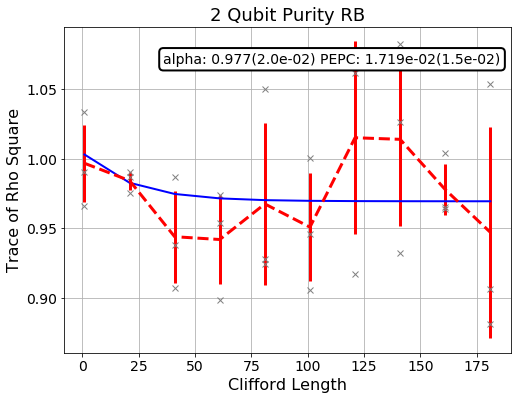

In [23]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_purity.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Purity RB'%(nQ), fontsize=18)

plt.show()

## Standard RB results

For comparison, we also print the standard RB fit results:

In [24]:
standard_result_list = []
count = 0
for rb_seed in range(len(rb_purity_circs)):
    for d in range(npurity):
        if d==0:
            standard_result_list.append(coherent_purity_result_list[count])
        count += 1

In [25]:
rbfit_standard = rb.RBFitter(standard_result_list, xdata, rb_opts['rb_pattern'])

In [26]:
print (rbfit_standard.fit)

[{'params': array([0.78230391, 0.98911505, 0.20928318]), 'params_err': array([0.04805313, 0.00139343, 0.04879022]), 'epc': 0.008163714509596742, 'epc_err': 0.0010565744742383136}]


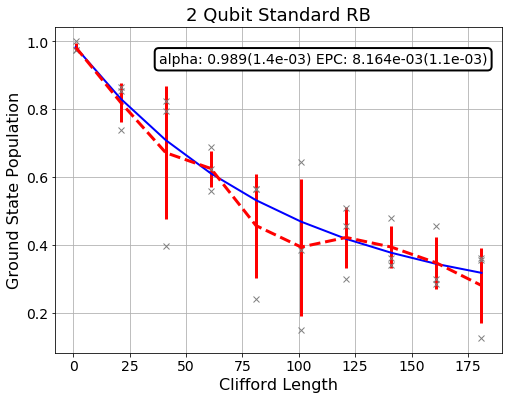

In [27]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rbfit_standard.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit Standard RB'%(nQ), fontsize=18)

plt.show()

In [28]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright